County Voting Data From https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910%2FDVN%2FVOQCHQ

In [1]:
# Input Information
YEAR = 2020

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
# Read CSV Files
df = pd.read_csv('../data/College Records - college-counties-2020.csv')
cvd = pd.read_csv('../data/countypres_2000-2020.csv')

In [4]:
# Clean input data to remove nulls and reset index
df = df.dropna()
df.reset_index(drop=True, inplace=True)

In [5]:
# Merge liberal and conservative votes in County Voting Data
cvd = cvd[cvd['party']!="OTHER"]
cvd = cvd.reset_index(drop=True)
PARTY_REPLACEMENTS = {"LIBERAL": ["DEMOCRAT", "GREEN"], "CONSERVATIVE": ["REPUBLICAN", "LIBERTARIAN"]}
for party, replacements in PARTY_REPLACEMENTS.items():
    cvd.loc[cvd['party'].isin(replacements), 'party'] = party
grouped = cvd.groupby(['year','state','county_name', 'party', 'totalvotes'], as_index=False)
cvd = grouped.agg({'candidatevotes':'sum'})
cvd.dropna(inplace=True)

In [6]:
# Calculate county scores
liberal_percents = []
conservative_percents = []
for i in range(len(df)):
    county = df.iloc[i]['County'].upper()
    state = df.iloc[i]['State'].upper()
    # Get the total votes and candidate votes for liberals and conservatives in cvd using the county, state, and year
    county = df.iloc[i]['County'].upper()
    state = df.iloc[i]['State'].upper()
    liberal_votes = cvd[(cvd['county_name']==county) & (cvd['state']==state) & (cvd['year']==YEAR) & (cvd['party']=='LIBERAL')]['candidatevotes'].sum()
    conservative_votes = cvd[(cvd['county_name']==county) & (cvd['state']==state) & (cvd['year']==YEAR) & (cvd['party']=='CONSERVATIVE')]['candidatevotes'].sum()
    total_votes = cvd[(cvd['county_name']==county) & (cvd['state']==state) & (cvd['year']==YEAR) & (cvd['party']=='LIBERAL')]['totalvotes'].sum()
    liberal_percent = liberal_votes / total_votes
    conservative_percent = conservative_votes / total_votes
    liberal_percents.append(liberal_percent)
    conservative_percents.append(conservative_percent)
df["Liberal Percents"] = liberal_percents
df["Conservative Percents"] = conservative_percents

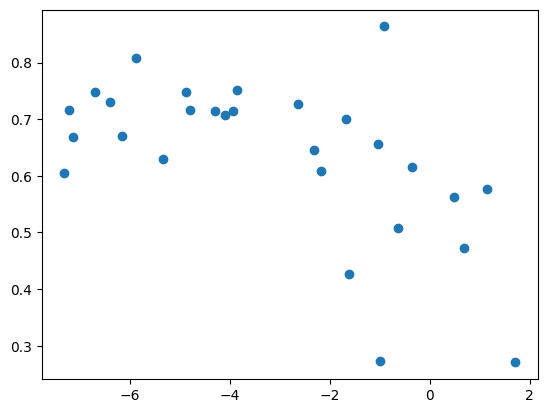

In [7]:
# Average Data for 4 years
plot_df = pd.DataFrame(columns=["College Score", "Liberal Percent"])
for row in df.iterrows():
    scores = [row[1][str(i)] for i in range(YEAR-4, YEAR)]
    average = np.mean(scores)
    plot_df.loc[len(plot_df)] = [average, row[1]["Liberal Percents"]]

# Plot Data
x = plot_df["College Score"]
y = plot_df["Liberal Percent"]
plt.scatter(x, y)

In [8]:
# Data scoring
x = plot_df[['College Score']]
y = plot_df['Liberal Percent']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Liberal Percent   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     12.05
Date:                Sun, 16 Jul 2023   Prob (F-statistic):            0.00183
Time:                        20:05:49   Log-Likelihood:                 20.962
No. Observations:                  28   AIC:                            -37.92
Df Residuals:                      26   BIC:                            -35.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5469      0.034     15.933      0.000       0.476       0.617
College Score    -0.0286      0.008     -3.471      0.002      -0.046      -0.012
==============================================================================
Omnibus:                        4.015   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.134   Jarque-Bera (JB):                2.486
Skew:                          -0.441   Prob(JB):                        0.289
Kurtosis:                       4.163   Cond. No.                         6.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""